## Import libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from math import *
from sklearn.metrics import mean_squared_error,mean_absolute_error
from fbprophet import Prophet
from mlens import metrics
import itertools
from fbprophet.diagnostics import cross_validation,performance_metrics

[MLENS] backend: threading


### Create font for visualization

In [3]:
font = {
        'color':  'black',
        'weight': 'normal',
        'size': 16
       }
%matplotlib inline

## Load data

In [4]:
sales_df = pd.read_csv("./sales.csv",sep=";")
categories_df = pd.read_csv("./categories.csv",sep=";")
traffic_df = pd.read_csv("./traffic.csv",sep=";")

## Merge table

In [5]:
df = sales_df.merge(traffic_df, on=["product_id",'week_starting_date'],how='left').merge(categories_df, on='product_id', how='inner')

## Fill empty rows

In [6]:
df['traffic'].fillna(0,inplace=True)

In [7]:
df.rename(columns={'week_starting_date':'date'},inplace=True)

## Some information about Dataset

In [8]:
df.head()

,date,product_id,sales,traffic,category_id
0,20191209,1990,1,1.0,0
1,20201123,1990,1,0.0,0
2,20201207,1990,1,0.0,0
3,20191202,1990,1,1.0,0
4,20201109,1990,2,1.0,0


In [9]:
df.describe()

,date,product_id,sales,traffic,category_id
count,1.057810e+05,105781.000000,105781.000000,105781.000000,105781.000000
mean,2.019652e+07,1542.355007,29.750588,25.365689,25.603596
std,4.936736e+03,905.754736,104.557434,89.082039,18.955310
min,2.019011e+07,1.000000,1.000000,0.000000,0.000000
25%,2.019090e+07,737.000000,5.000000,2.000000,10.000000
50%,2.020030e+07,1532.000000,9.000000,7.000000,22.000000
75%,2.020082e+07,2310.000000,21.000000,20.000000,36.000000
max,2.020123e+07,3135.000000,5465.000000,9914.000000,91.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105781 entries, 0 to 105780
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         105781 non-null  int64  
 1   product_id   105781 non-null  int64  
 2   sales        105781 non-null  int64  
 3   traffic      105781 non-null  float64
 4   category_id  105781 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 4.8 MB


## Correlation between variables

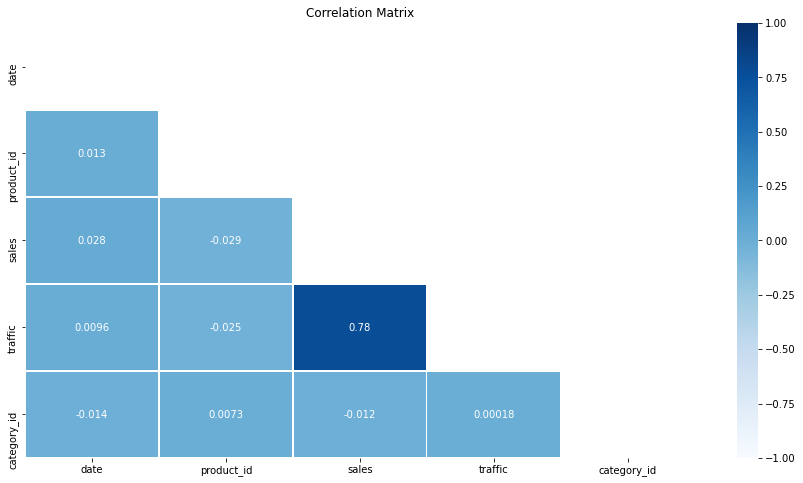

In [11]:
plt.figure(figsize=(15,8))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True,linewidths=0.2,vmin=-1,vmax=1,mask=mask, cmap='Blues',center=0)
plt.title('Correlation Matrix')
plt.show()

#### Correlation between sales and traffic is quite strong

## Prepare data part 1

In [12]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [13]:
df2 = df.copy(deep=True)

In [14]:
df2['year'] = df['date'].dt.year
df2['month'] = df['date'].dt.month
df2['day'] = df['date'].dt.day

## Some visualization

<AxesSubplot:title={'center':'Sales by Year'}, xlabel='Years', ylabel='Sales in billions'>

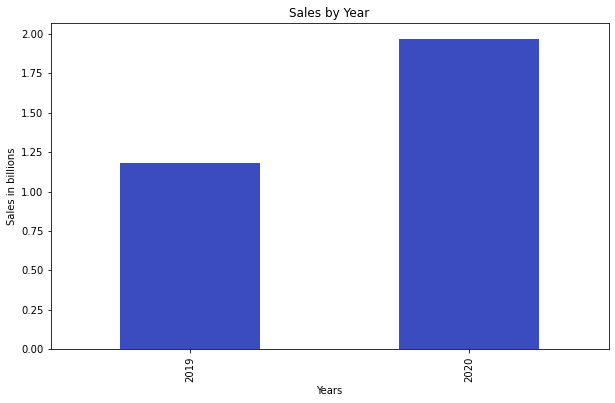

In [15]:
sales_year = df2.groupby('year').agg(sales_target =('sales','sum'))
sales_year=sales_year/1000000
sales_year.plot(kind='bar', title = 'Sales by Year', figsize = (10,6), cmap='coolwarm', xlabel="Years",ylabel="Sales in billions",legend=False)

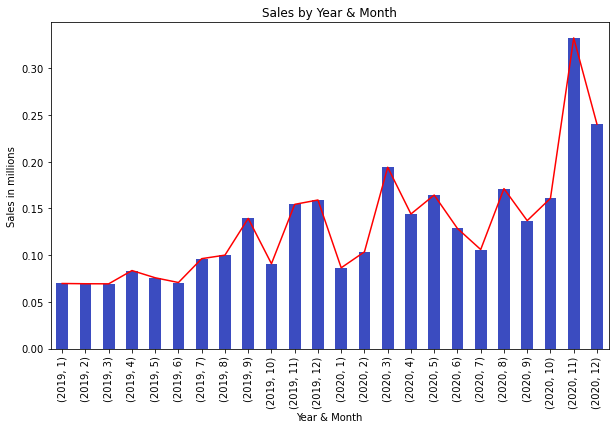

In [16]:
sales_year_month = df2.groupby(['year','month']).agg(sales_target =('sales','sum'))
sales_year_month=sales_year_month/1000000
ax=sales_year_month.plot(kind='line', title = 'Sales by Year & Month', figsize = (10,6), color='red', xlabel="Year & Month",ylabel="Sales in millions",legend=False)
sales_year_month.plot(kind='bar', title = 'Sales by Year & Month', figsize = (10,6), cmap='coolwarm', xlabel="Year & Month",ylabel="Sales in millions",legend=False,ax=ax);

<AxesSubplot:title={'center':'Best 10 selling product_id'}, xlabel='Product ID', ylabel='Sales'>

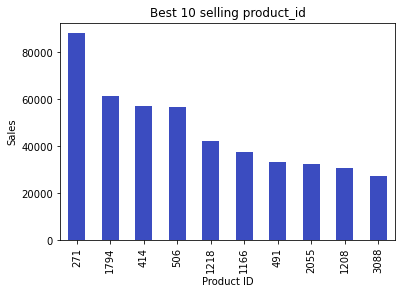

In [17]:
best_product = pd.DataFrame(df2.groupby('product_id').sum()['sales'])
best_product.sort_values(by=['sales'], inplace=True, ascending=False)
top_prods = best_product.head(10)
top_prods.plot(kind="bar", title = 'Best 10 selling product_id', cmap='coolwarm', xlabel="Product ID",ylabel="Sales",legend=False)

<AxesSubplot:title={'center':'Best 10 selling category_id'}, xlabel='Category ID', ylabel='Sales'>

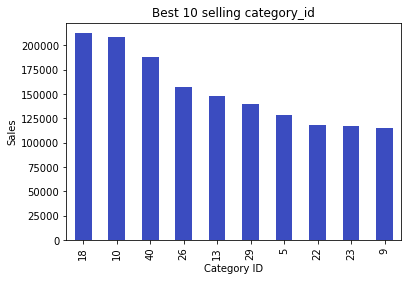

In [18]:
best_product = pd.DataFrame(df2.groupby('category_id').sum()['sales'])
best_product.sort_values(by=['sales'], inplace=True, ascending=False)
top_prods = best_product.head(10)
top_prods.plot(kind="bar", title = 'Best 10 selling category_id', cmap='coolwarm', xlabel="Category ID",ylabel="Sales",legend=False)

## Prepare data part 2

In [19]:
data=df.groupby(['date']).agg({'traffic': 'sum','sales': 'sum','category_id':'count'}).reset_index()
data = data.set_index('date')
data.head()

,traffic,sales,category_id
date,,,
2019-01-07,17856.0,16958,692
2019-01-14,18113.0,18187,708
2019-01-21,19897.0,18344,727
2019-01-28,10042.0,16164,729
2019-02-04,13492.0,18168,739


In [20]:
print("missing_data:", data.isna().sum())
print("unique dates:", data.index.nunique())

missing_data: traffic        0
sales          0
category_id    0
dtype: int64
unique dates: 104


## Visualise the data

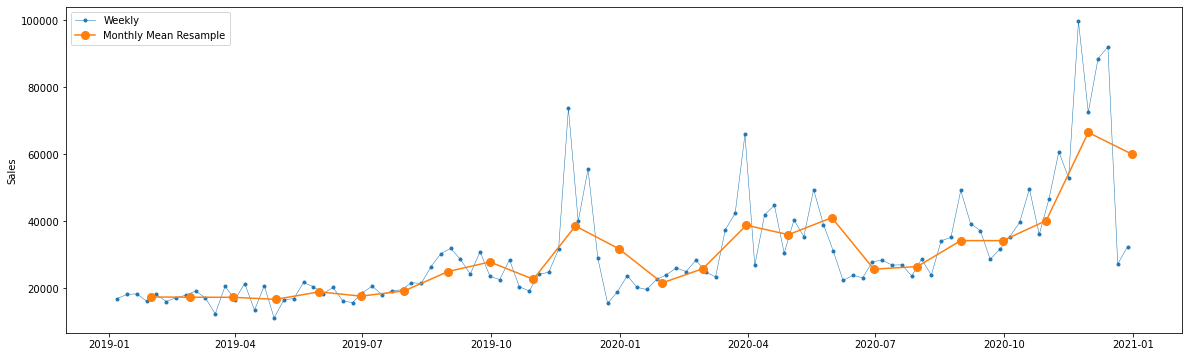

In [21]:
y = data[['sales']]
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Sales')
ax.legend();

#### By looking at the graph of sales data above, we can see a general increasing trend with no clear pattern of seasonal or cyclical changes

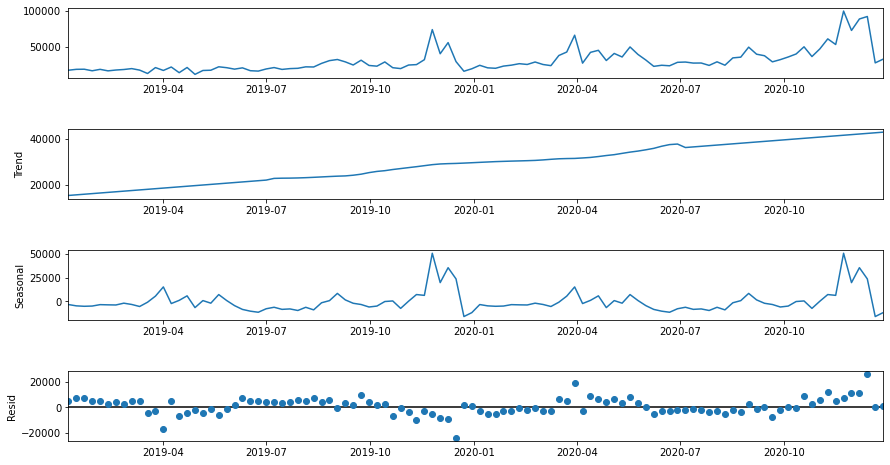

In [22]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

#### After looking at the four pieces of decomposed graphs, we can tell that our sales dataset has an overall increasing trend as well as a yearly seasonality.

## Check for stationarity

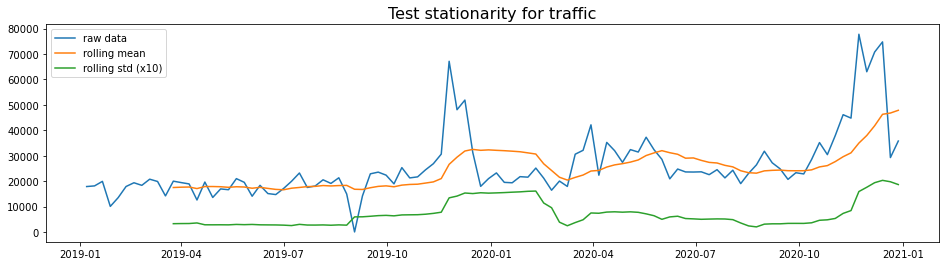

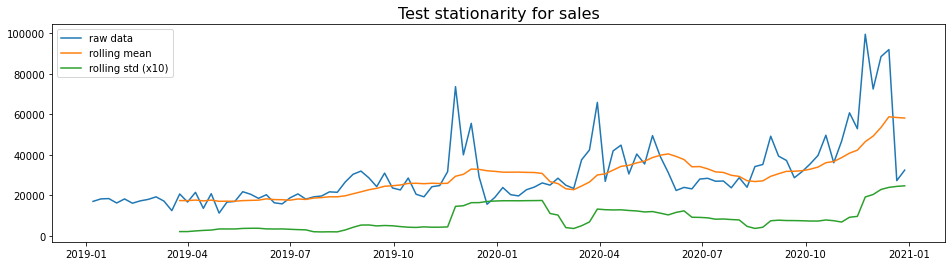

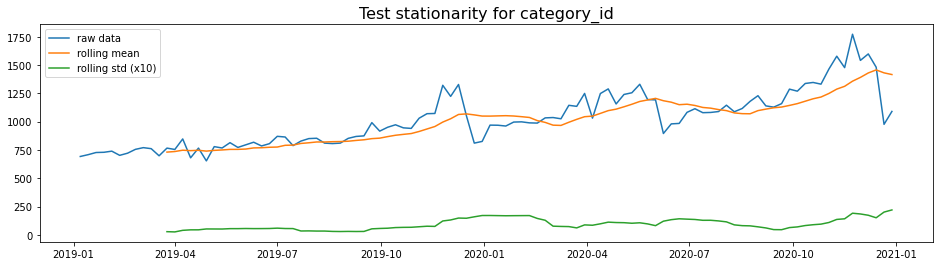

In [23]:
for col in data.columns:
    y = data[col]
    rolmean = pd.Series(y).rolling(window=12).mean() 
    rolstd = pd.Series(y).rolling(window=12).std()   
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(y, label= 'raw data')
    ax.plot(rolmean, label='rolling mean')
    ax.plot(rolstd, label='rolling std (x10)')
    plt.title("Test stationarity for {}".format(col),fontdict=font)
    ax.legend()


#### In all 3 graphs both the mean and standard deviation for stationary data does not change much over time But in this case, since the y-axis has such a large scale, we can not confidently conclude that our data is stationary by simply viewing the above graph.

In [24]:
for col in data.columns:
    y = data[col]
    print('Is the {} stationary ?'.format(col))
    test = adfuller(y.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(test[0]))
    print('P-value = {:.3f}'.format(test[1]))
    print('Critical values :')
    for k, v in test[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<test[0] else '', 100-int(k[:-1])))
    print("-"*100)

Is the traffic stationary ?
Test statistic = -2.531
P-value = 0.108
Critical values :
	1%: -3.498198082189098 - The data is not stationary with 99% confidence
	5%: -2.891208211860468 - The data is not stationary with 95% confidence
	10%: -2.5825959973472097 - The data is not stationary with 90% confidence
----------------------------------------------------------------------------------------------------
Is the sales stationary ?
Test statistic = -2.782
P-value = 0.061
Critical values :
	1%: -3.498198082189098 - The data is not stationary with 99% confidence
	5%: -2.891208211860468 - The data is not stationary with 95% confidence
	10%: -2.5825959973472097 - The data is  stationary with 90% confidence
----------------------------------------------------------------------------------------------------
Is the category_id stationary ?
Test statistic = -2.059
P-value = 0.262
Critical values :
	1%: -3.4961490537199116 - The data is not stationary with 99% confidence
	5%: -2.8903209639580556 

#### For 3 columns the p-value is greater than the significance level 0.05, so we stay with the null hypothesis and conclude that the data are non-stationary

## Make the data stationary

In [25]:
# Detrending
for col in data.columns:
    y = data[col]
    y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()
    data[col] = y_detrend
    
for col in data.columns:
    y = data[col]
    print('Is the {} stationary ?'.format(col))
    test = adfuller(y.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(test[0]))
    print('P-value = {:.3f}'.format(test[1]))
    print('Critical values :')
    for k, v in test[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<test[0] else '', 100-int(k[:-1])))
    print("-"*100)

Is the traffic stationary ?
Test statistic = -5.117
P-value = 0.000
Critical values :
	1%: -3.503514579651927 - The data is  stationary with 99% confidence
	5%: -2.893507960466837 - The data is  stationary with 95% confidence
	10%: -2.583823615311909 - The data is  stationary with 90% confidence
----------------------------------------------------------------------------------------------------
Is the sales stationary ?
Test statistic = -4.566
P-value = 0.000
Critical values :
	1%: -3.506057133647011 - The data is  stationary with 99% confidence
	5%: -2.8946066061911946 - The data is  stationary with 95% confidence
	10%: -2.5844100201994697 - The data is  stationary with 90% confidence
----------------------------------------------------------------------------------------------------
Is the category_id stationary ?
Test statistic = -4.897
P-value = 0.000
Critical values :
	1%: -3.503514579651927 - The data is  stationary with 99% confidence
	5%: -2.893507960466837 - The data is  stati

#### Now we can see that everything is stationary because p-value < 0.05 

## Create Training & Testing Datasets

In [26]:
train = data[:'2020-05-04']
test = data['2020-05-04':]

In [27]:
train = train.reset_index()[['date','sales','traffic','category_id']].rename({'date':'ds','sales':'y'}, axis='columns')
test = test.reset_index()[['date','sales','traffic','category_id']].rename({'date':'ds','sales':'y'}, axis='columns')
train.fillna(value=0,inplace=True)

## Prophet

### Search the best parameters

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

for params in all_params:
    m = Prophet(**params).fit(train)
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

In [ ]:
best_params = all_params[np.argmin(rmses)]
print("The best parameters => {}".format(best_params))

## Create model

In [29]:
model = Prophet(**params,interval_width=0.95,yearly_seasonality=True)
model.fit(train)
future_test = model.predict(test)
future = model.make_future_dataframe(periods=3, freq='t')
forecast = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Model fitting

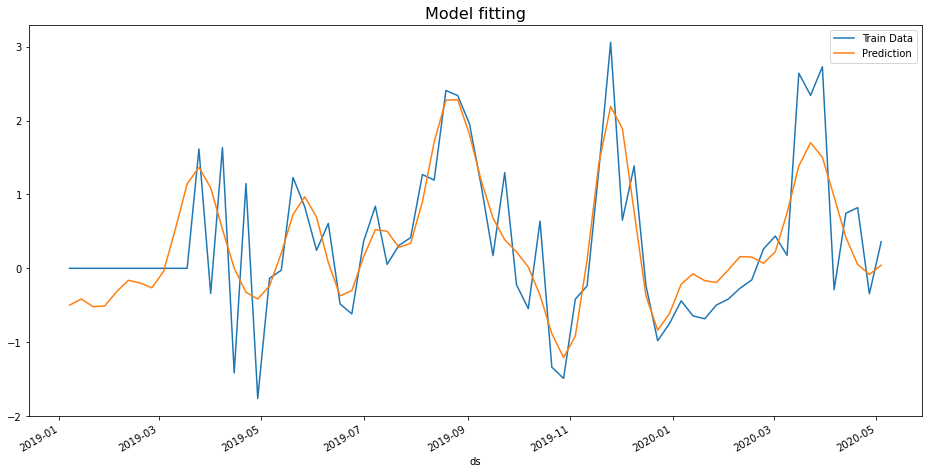

In [30]:
gr=pd.concat([train.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
gr.plot(ax=ax)
plt.title("Model fitting",fontdict=font)
plt.legend(['Train Data','Prediction'])

#### We can see that the model has fitted the data reasonably well but not excessively 

## Plot prediction

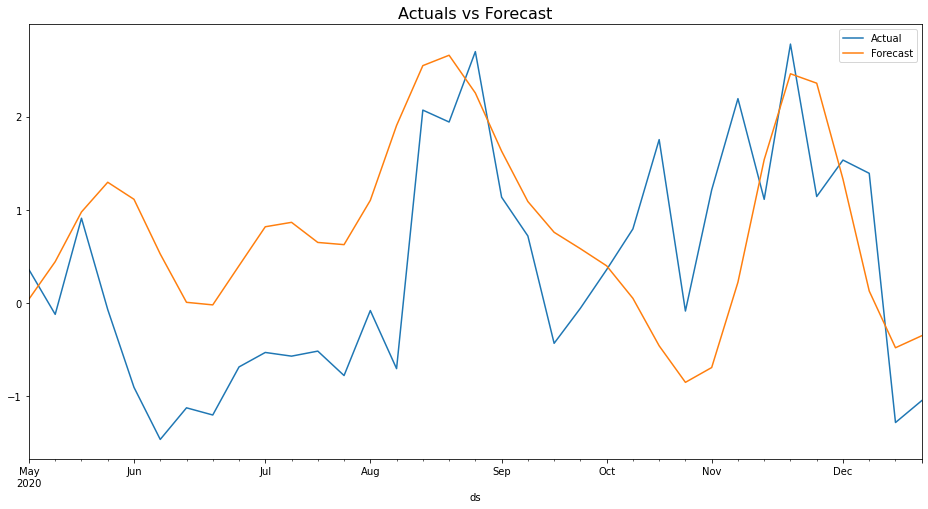

In [31]:
gr1=pd.concat([test.set_index('ds')['y'],future_test.set_index('ds')['yhat']],axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
gr1.plot(ax=ax)
plt.title("Actuals vs Forecast",fontdict=font)
plt.legend(['Actual','Forecast'])

Text(0.5, 1.0, 'Prediction')

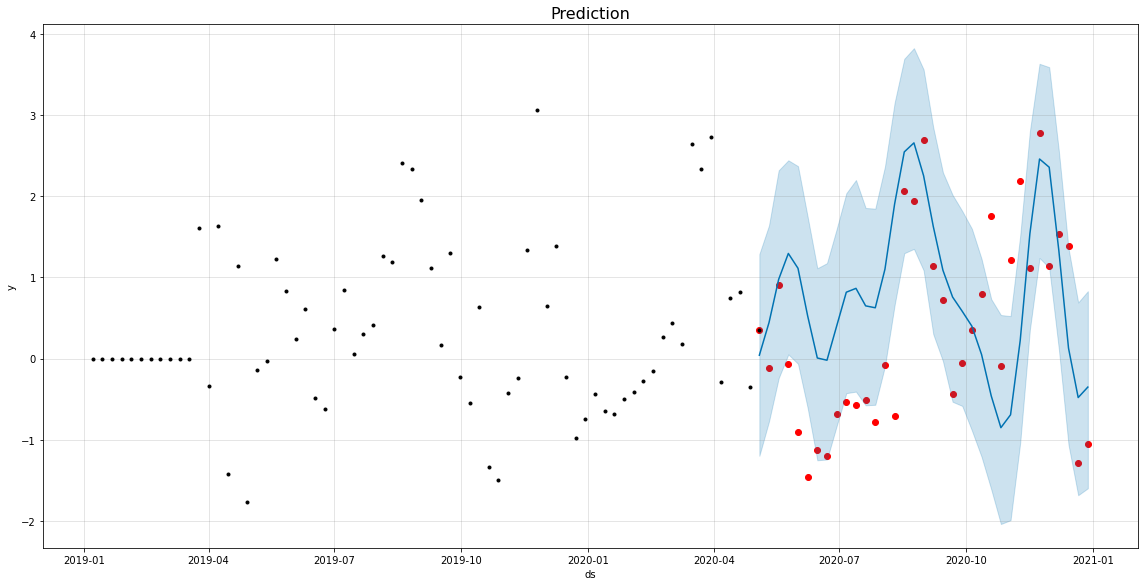

In [32]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(test.ds, test['y'], color='r')
fig=model.plot(future_test,figsize=(16, 8),ax=ax)
plt.title("Prediction",fontdict=font)

## Value prediction for next 3 weeks

In [41]:
d1=pd.DataFrame(test.set_index('ds')['y'])
d2=pd.DataFrame(future_test.set_index('ds')['yhat'])
d3 = d1.merge(d2, on=["ds"],how='inner')
d3.rename(columns={'y':'value','yhat':'predict','ds':'date'},inplace=True)
d3.index.names = ['date']
d3.head(3)

,value,predict
date,,
2020-05-04,0.358606,0.042627
2020-05-11,-0.120712,0.444294
2020-05-18,0.909713,0.976823


## Plot the components of the model

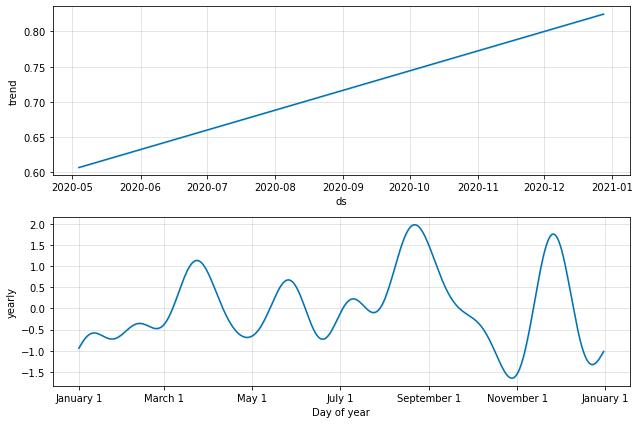

In [62]:
fig2 = model.plot_components(future_test)

#### We can see that dataset has an overall increasing trend and certain seasonality 

## Metrics for model

In [63]:
wape=metrics.wape(test["y"],future_test["yhat"])
print("Weighted Absolute Percent Error = {}".format(wape))
mse=mean_squared_error(test["y"],future_test["yhat"])
print("Mean Squared Error = {}".format(mse))
mae=mean_absolute_error(test["y"],future_test["yhat"])
print("Mean Absolute Error = {}".format(mae))
mape=metrics.mape(test["y"],future_test["yhat"])
print("Mean Average Percentage Error = {}".format(mape))

Weighted Absolute Percent Error = 1.0001862115839362
Mean Squared Error = 1.4493266257140722
Mean Absolute Error = 1.0209684318909427
Mean Average Percentage Error = 2.6834041598160923
